In [37]:
import pandas as pd
import sys
import json
import ast
import matplotlib.pyplot as plt

## EDA charts

In [42]:
arxivFP = '../data/arxivData.json'
arx = pd.read_json(arxivFP)
arx['tag'] = arx['tag'].apply(ast.literal_eval)
arx.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [3]:
arx.describe()

,day,month,year
count,41000.000000,41000.000000,41000.000000
mean,15.833293,6.547488,2014.484073
std,8.699371,3.525254,3.685414
min,1.000000,1.000000,1993.000000
25%,8.000000,3.000000,2013.000000
50%,16.000000,6.000000,2016.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


(array([  156.,    48.,   369.,   320.,   604.,   570.,  2158.,  4077.,
        11004., 21694.]),
 array([1993. , 1995.5, 1998. , 2000.5, 2003. , 2005.5, 2008. , 2010.5,
        2013. , 2015.5, 2018. ]),
 <BarContainer object of 10 artists>)

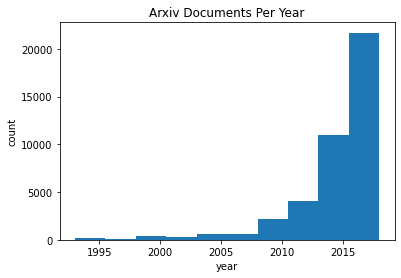

In [102]:
doc_per_year = arx['year'].value_counts()
plt.xlabel('year')
plt.ylabel('count')
plt.title('Arxiv Documents Per Year')
plt.hist(arx['year'])

Firstly, looking at the number of documents per year for the arxiv dataset. We notice that the amount of data grows exponentially as we approach the present. This is important to keep in mind since AutoPhrase works less well when dealing with small samples of data. We should keep this in mind when working with years that have less than 100 documents (citation needed). This could also be useful in explaining differences in AutoPhrase output when dealing with change from older to younger years.

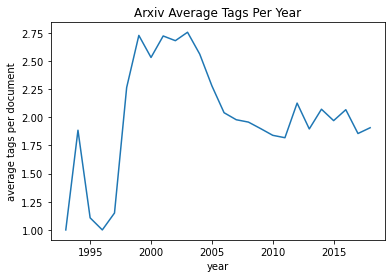

In [57]:
arx_taginfo = arx.loc[:, ('year', 'tag')]
arx_taginfo['num_tags'] = arx_taginfo['tag'].apply(lambda x: len(x))
arx_tagpy = arx_taginfo.groupby('year').mean()['num_tags']
plt.xlabel('year')
plt.ylabel('average tags per document')
plt.title('Arxiv Average Tags Per Year')
plt.plot(arx_tagpy)

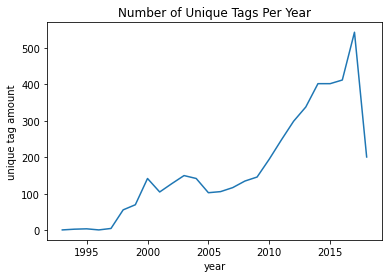

In [100]:
arx_expandtag = arx_taginfo.explode('tag')
arx_expandtag['tag'] = arx_expandtag['tag'].apply(lambda x: x['term'])
arx_extagpy = arx_expandtag.groupby('year').agg({
    'tag': lambda x: len(x.unique())
})
plt.title('Number of Unique Tags Per Year')
plt.xlabel('year')
plt.ylabel('unique tag amount')
plt.plot(arx_extagpy)

These next two graphs show data relating to the tags attached to each document. These tags describe a rough subject domain that a document belongs to. The first graph shows how the average amount of tags per document fluctuates over the years. We see around 3 sections of interest. From 1993 to 1997, we see that average tag numbers per document stays between 1 and 2. Then from 1998 to 2003, average tag numbers jump to an average between 2.5 and 2.75 tags per document. Finally from 2005 onwards, average tags per document fluctuates around 2 tags per document. Since we will be using these tags as comparison for AutoPhrase's performance on our yearly document data, knowing the amount of tags that a document is labeled by can help us catch differences in comparison between these sections.

The next graph shows the amount of unique tags gathered from the documents of that year. This allows us to see how the new category of tags changes from year to year and prepares us for differences in comparison. We see that the number of unique tags per year steadily rises. This makes sense since new categories would be prepared when a suitable topic of interest deserves a new tag. This does mean that we need to be careful with comparisons across long time gaps as tags formerly used as a whole might be divided into new tags in the future. There is also a noticeable drop in tag count for the last year. Looking at the value counts of documents per year a little closer, we notice that the year of 2018 does have considerably less documents compared to the previous year. This could be because the Arxiv dataset only contains a partial amount of documents from 2018 therefore containing less overall documents and unique tags. This should be considered when comparing the 2018 arxiv data to other years.

In [96]:
arx_overtags = arx_expandtag.groupby(['year', 'tag']).count().reset_index()
arx_overtags.head()

,year,tag,num_tags
0,1993,cs.AI,6
1,1994,cmp-lg,108
2,1994,cs.AI,14
3,1994,cs.CL,108
4,1995,cmp-lg,1


This contains a small look at how we can separate each year and see the counts of individual tags. This will provide great case study comparison for important tags versus AutoPhrase's phrase miner.

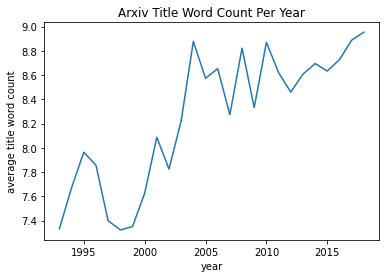

In [23]:
arx_tinfo = arx.loc[:, ('year', 'title')]
arx_tinfo['word count'] = arx_tinfo['title'].str.split().apply(len)
arx_tpy = arx_tinfo.groupby('year').agg({
    'title': ' '.join,
    'word count': 'mean'
})
plt.xlabel('year')
plt.ylabel('average title word count')
plt.title('Arxiv Title Word Count Per Year')
plt.plot(arx_tpy.index, arx_tpy['word count'])

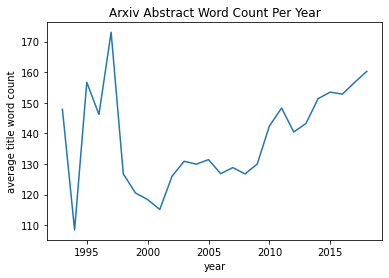

In [24]:
arx_abinfo = arx.loc[:, ('year', 'summary')]
arx_abinfo['word count'] = arx_abinfo['summary'].str.split().apply(len)
arx_abpy = arx_abinfo.groupby('year').agg({
    'summary': ' '.join,
    'word count': 'mean'
})
plt.xlabel('year')
plt.ylabel('average title word count')
plt.title('Arxiv Abstract Word Count Per Year')
plt.plot(arx_abpy.index, arx_abpy['word count'])

These last two graphs compare average title length and abstract length per year. This is important to keep in mind since this could also contribute to AutoPhrase performing differently if different years have significantly different word counts combined with different document counts. We see that title length follows a general upward trend. Combined with how the document count follows a similar trend, we should be careful of our conclusions when working with title alone. Meanwhile abstract length follows a more erratic path with wild fluctuation for early years before assuming an general upward trend as well. Abstract length averages out between the years to be somewhat consistent in length. This means that with regard to abstract, emphasis would be Considering that abstract overall contains much more phrases than the title.